### Members:
- 109065511 張宜禎
- 109062562 蔡哲維
- 108065425 丘騏銘

# Importing and setting up Tensorflow

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime

import sys
sys.path.insert(0, './evaluate')
import evaluate as eval_gen

%matplotlib inline
import matplotlib.pyplot as plt
import cv2

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus, 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)  

2 Physical GPUs, 2 Logical GPUs


In [3]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.WARN)

# Config

In [4]:
# common params
IMAGE_SIZE = 448
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
DATA_PATH = './data/pascal_voc_training_data.txt'
IMAGE_DIR = './data/VOCdevkit_train/VOC2007/JPEGImages/'
VAL_GT_DIR = './mAP/input/ground-truth/'
VAL_PRED_DIR = './mAP/input/detection-results/'
TRAIN_DATA_SIZE = 5011

DATA_PARALLELISM = False
if len(logical_gpus) > 1:
    DATA_PARALLELISM = True

# YOLO params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

VGG_TRAINABLE = False

# training params
# MOMENTUM = 0.9

BATCH_SIZE = 40 * len(logical_gpus)
EPOCHS = 135
LEARNING_RATE = 1.5*1e-5

# generate prediction
CONF_THRESHOLD = 5e-2
OVERLAP_THRESHOLD = 0.4

In [5]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

# Generate dataset

## Data Augmentation

After we observe the data, we find out that the data is very imbalance.

There are lots of people annotations in the data, while other annotations such as those belong to dining table are very few.

To compensate this, we do the data augmentation. Specifically, we emphasize on increasing the number of images whose labels are too few (low frequency labels).

The method we do augmentation on all the images contains:
1. Do the cropping on images -> left_up, left_bottom, right_up, right_bottom
2. Do left_right flipping

One thing worth mentioning is that, when we do the cropping, if the bounding box of the cropped image doesn't overlap the original bounding box for the threshold we set (CROP_BBOX_THRESHOLD = 70%), we will drop the bounding box. 

The method we emphasize on doing augmentation on those low frequency label images contains:
1. Tuning the saturation value of images
2. Tuning the brightness value of images
3. Tuning the HSV randomly of those cropped images

Another thing worth mentioning here is that, the way we decide if the image belongs to imbalance images or not is going through the annotations in the image, and checking if the least proportion of annotations appear in the image is lower than the threshold we set (PROPORTION_THRESHOLD = 5%). If the condition is met, we then check if the people annotations appear in the image.
If people annotations don't appear, we can directly augment the image. Otherwise, we generate a random number, and check if the random number is over the threshold we set (RANDOM_GEN_THRESHLD = 40%). If yes, we then do augmentation on it, otherwise, we pass the image.

Below, is the code we generate data.


In [6]:
RANDOM_GEN_THRESHLD = 0.4
PROPORTION_THRESHOLD = 0.05
CROP_BBOX_THRESHOLD = 0.7

class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 224 x 224
    - converts to VGG 19 data type
    - shuffles the input
    - builds batches
    """

    def __init__(self,is_train_set=False, data_list=[], gen_map_file=False):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        self.image_height_width = []
        self.cropped_left_up_image_names = []
        self.cropped_left_up_record_list = []
        self.cropped_left_up_object_num_list = []
        self.cropped_right_up_image_names = []
        self.cropped_right_up_record_list = []
        self.cropped_right_up_object_num_list = []
        self.cropped_left_down_image_names = []
        self.cropped_left_down_record_list = []
        self.cropped_left_down_object_num_list = []
        self.cropped_right_down_image_names = []
        self.cropped_right_down_record_list = []
        self.cropped_right_down_object_num_list = []
        # those images have inbalance items, do hsv augmentation
        self.inbalance_image_names = []
        self.inbalance_record_list = []
        self.inbalance_object_num_list = []
        # those cropped images have inbalance items, do hsv augmentation
        self.cropped_left_up_hsv_image_names = []
        self.cropped_left_up_hsv_record_list = []
        self.cropped_left_up_hsv_object_num_list = []
        self.cropped_left_down_hsv_image_names = []
        self.cropped_left_down_hsv_record_list = []
        self.cropped_left_down_hsv_object_num_list = []
        self.cropped_right_up_hsv_image_names = []
        self.cropped_right_up_hsv_record_list = []
        self.cropped_right_up_hsv_object_num_list = []
        self.cropped_right_down_hsv_image_names = []
        self.cropped_right_down_hsv_record_list = []
        self.cropped_right_down_hsv_object_num_list = []
        # filling the record_list
        input_file = open(DATA_PATH, 'r')
        # image num
        self.image_num = 0
        # class_dict init {class_number: # of the class}
        self.class_dict = {}
        # total obeject number
        self.total_object = 0
        # count the object num distribution in the whole original dataset
        self.obj_num_distribution = {}
        
        self.is_train_set = is_train_set
        
        np.random.seed(0)
        self.random_list = np.random.random_sample((20000,))
        self.random_counter = 0
        
        for i in range(20):
            self.class_dict[float(i)] = 0

        for line in input_file:
            # Besides the original image, we split it into four part, and do flip on it
            if self.image_num in data_list:
                line = line.strip()
                ss = line.split(' ')
                self.image_names.append(ss[0])

                ## Reading the image to get image width and height
                image_file = tf.io.read_file(IMAGE_DIR+ss[0])
                image = tf.io.decode_jpeg(image_file, channels=3)
                h = tf.shape(image)[0]
                w = tf.shape(image)[1]
                self.image_height_width.append((h,w))

                self.record_list.append([float(num) for num in ss[1:]])

                self.object_num_list.append(min(len(self.record_list[-1])//5, 
                                                MAX_OBJECTS_PER_IMAGE))
                # Count the object num distribution
                obj_num = min(len(self.record_list[-1])//5, MAX_OBJECTS_PER_IMAGE)
                if obj_num in self.obj_num_distribution:
                    self.obj_num_distribution[obj_num] += 1
                else:
                    self.obj_num_distribution[obj_num] = 1
                if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
                    # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                    self.record_list[-1] = self.record_list[-1] +\
                    [0., 0., 0., 0., 0.]*\
                    (MAX_OBJECTS_PER_IMAGE-len(self.record_list[-1])//5)

                elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
                   # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                    self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]
                # generate file for calculate mAP
                if not self.is_train_set and gen_map_file:
                    f = open(VAL_GT_DIR + ss[0][:-4] + '.txt', 'w')

                    for label_idx in range(self.object_num_list[-1]):
                        class_name = classes_name[int(self.record_list[-1][label_idx * 5 + 4])]
                        xmin = self.record_list[-1][label_idx * 5 + 0]
                        ymin = self.record_list[-1][label_idx * 5 + 1]
                        xmax = self.record_list[-1][label_idx * 5 + 2]
                        ymax = self.record_list[-1][label_idx * 5 + 3]
                        output_str = class_name + ' ' + str(xmin) + ' ' + str(ymin) + ' ' + str(xmax) + ' ' + str(ymax) + '\n'
                        f.write(output_str)
                    f.close()
            self.image_num+=1
        
        if self.is_train_set == True:
            self.image_num+=5
            for image_name, records, height_width_pair in zip(self.image_names, self.record_list, self.image_height_width):
                cropped_left_up_record = []
                cropped_left_up_object_num = 0.
                for record_idx in range(0,len(records),5):

                    if (records[record_idx:record_idx+5] == [0.,0.,0.,0.,0.]):
                        break
                    image_height = height_width_pair[0]
                    image_width = height_width_pair[1]
                    xmin = records[record_idx]
                    ymin = records[record_idx+1]
                    xmax = records[record_idx+2]
                    ymax = records[record_idx+3]

                    b_width = xmax - xmin
                    b_height = ymax - ymin
                    b_area = b_width*b_height

                    cropped_xmin = min(xmin,int(image_width/2))
                    cropped_ymin = min(ymin,int(image_height/2))
                    cropped_xmax = min(xmax,int(image_width/2))
                    cropped_ymax = min(ymax,int(image_height/2))

                    cropped_b_width = cropped_xmax - cropped_xmin
                    cropped_b_height = cropped_ymax - cropped_ymin
                    cropped_b_area = cropped_b_width*cropped_b_height

                    if float(cropped_b_area)/float(b_area) >= CROP_BBOX_THRESHOLD:
                        cropped_left_up_record.append(cropped_xmin)
                        cropped_left_up_record.append(cropped_ymin)
                        cropped_left_up_record.append(cropped_xmax)
                        cropped_left_up_record.append(cropped_ymax)
                        cropped_left_up_record.append(records[record_idx+4])
                        cropped_left_up_object_num+= 1.

                if cropped_left_up_object_num == 0.:
                    continue
                else:
                    if len(cropped_left_up_record) < MAX_OBJECTS_PER_IMAGE*5:
                        # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                        cropped_left_up_record = cropped_left_up_record +\
                        [0., 0., 0., 0., 0.]*\
                        (MAX_OBJECTS_PER_IMAGE-len(cropped_left_up_record)//5)
                    self.cropped_left_up_image_names.append(image_name)
                    self.cropped_left_up_record_list.append(cropped_left_up_record)
                    self.cropped_left_up_object_num_list.append(cropped_left_up_object_num)

            for image_name, records, height_width_pair in zip(self.image_names, self.record_list, self.image_height_width):
                cropped_left_down_record = []
                cropped_left_down_object_num = 0.
                for record_idx in range(0,len(records),5):

                    if (records[record_idx:record_idx+5] == [0.,0.,0.,0.,0.]):
                        break
                    image_height = height_width_pair[0]
                    image_width = height_width_pair[1]
                    xmin = records[record_idx]
                    ymin = records[record_idx+1]
                    xmax = records[record_idx+2]
                    ymax = records[record_idx+3]

                    b_width = xmax - xmin
                    b_height = ymax - ymin
                    b_area = b_width*b_height

                    cropped_xmin = min(xmin,int(image_width/2))
                    cropped_ymin = max(ymin,int(image_height/2))
                    cropped_xmax = min(xmax,int(image_width/2))
                    cropped_ymax = max(ymax,int(image_height/2))

                    cropped_b_width = cropped_xmax - cropped_xmin
                    cropped_b_height = cropped_ymax - cropped_ymin
                    cropped_b_area = cropped_b_width*cropped_b_height

                    if float(cropped_b_area)/float(b_area) >= CROP_BBOX_THRESHOLD:
                        cropped_left_down_record.append(cropped_xmin)
                        cropped_left_down_record.append(cropped_ymin - int(image_height/2))
                        cropped_left_down_record.append(cropped_xmax)
                        cropped_left_down_record.append(cropped_ymax - int(image_height/2))
                        cropped_left_down_record.append(records[record_idx+4])
                        cropped_left_down_object_num+= 1.

                if cropped_left_down_object_num == 0.:
                    continue
                else:
                    if len(cropped_left_down_record) < MAX_OBJECTS_PER_IMAGE*5:
                        # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                        cropped_left_down_record = cropped_left_down_record +\
                        [0., 0., 0., 0., 0.]*\
                        (MAX_OBJECTS_PER_IMAGE-len(cropped_left_down_record)//5)
                    self.cropped_left_down_image_names.append(image_name)
                    self.cropped_left_down_record_list.append(cropped_left_down_record)
                    self.cropped_left_down_object_num_list.append(cropped_left_down_object_num)

            for image_name, records, height_width_pair in zip(self.image_names, self.record_list, self.image_height_width):
                cropped_right_up_record = []
                cropped_right_up_object_num = 0.
                for record_idx in range(0,len(records),5):

                    if (records[record_idx:record_idx+5] == [0.,0.,0.,0.,0.]):
                        break
                    image_height = height_width_pair[0]
                    image_width = height_width_pair[1]
                    xmin = records[record_idx]
                    ymin = records[record_idx+1]
                    xmax = records[record_idx+2]
                    ymax = records[record_idx+3]

                    b_width = xmax - xmin
                    b_height = ymax - ymin
                    b_area = b_width*b_height

                    cropped_xmin = max(xmin,int(image_width/2))
                    cropped_ymin = min(ymin,int(image_height/2))
                    cropped_xmax = max(xmax,int(image_width/2))
                    cropped_ymax = min(ymax,int(image_height/2))

                    cropped_b_width = cropped_xmax - cropped_xmin
                    cropped_b_height = cropped_ymax - cropped_ymin
                    cropped_b_area = cropped_b_width*cropped_b_height

                    if float(cropped_b_area)/float(b_area) >= CROP_BBOX_THRESHOLD:
                        cropped_right_up_record.append(cropped_xmin-int(image_width/2))
                        cropped_right_up_record.append(cropped_ymin)
                        cropped_right_up_record.append(cropped_xmax-int(image_width/2))
                        cropped_right_up_record.append(cropped_ymax)
                        cropped_right_up_record.append(records[record_idx+4])
                        cropped_right_up_object_num+= 1.

                if cropped_right_up_object_num == 0.:
                    continue
                else:
                    if len(cropped_right_up_record) < MAX_OBJECTS_PER_IMAGE*5:
                        # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                        cropped_right_up_record = cropped_right_up_record +\
                        [0., 0., 0., 0., 0.]*\
                        (MAX_OBJECTS_PER_IMAGE-len(cropped_right_up_record)//5)
                    self.cropped_right_up_image_names.append(image_name)
                    self.cropped_right_up_record_list.append(cropped_right_up_record)
                    self.cropped_right_up_object_num_list.append(cropped_right_up_object_num)

            for image_name, records, height_width_pair in zip(self.image_names, self.record_list, self.image_height_width):
                cropped_right_down_record = []
                cropped_right_down_object_num = 0.
                for record_idx in range(0,len(records),5):

                    if (records[record_idx:record_idx+5] == [0.,0.,0.,0.,0.]):
                        break
                    image_height = height_width_pair[0]
                    image_width = height_width_pair[1]
                    xmin = records[record_idx]
                    ymin = records[record_idx+1]
                    xmax = records[record_idx+2]
                    ymax = records[record_idx+3]

                    b_width = xmax - xmin
                    b_height = ymax - ymin
                    b_area = b_width*b_height

                    cropped_xmin = max(xmin,int(image_width/2))
                    cropped_ymin = max(ymin,int(image_height/2))
                    cropped_xmax = max(xmax,int(image_width/2))
                    cropped_ymax = max(ymax,int(image_height/2))

                    cropped_b_width = cropped_xmax - cropped_xmin
                    cropped_b_height = cropped_ymax - cropped_ymin
                    cropped_b_area = cropped_b_width*cropped_b_height

                    if float(cropped_b_area)/float(b_area) >= CROP_BBOX_THRESHOLD:
                        cropped_right_down_record.append(cropped_xmin-int(image_width/2))
                        cropped_right_down_record.append(cropped_ymin-int(image_height/2))
                        cropped_right_down_record.append(cropped_xmax-int(image_width/2))
                        cropped_right_down_record.append(cropped_ymax-int(image_height/2))
                        cropped_right_down_record.append(records[record_idx+4])
                        cropped_right_down_object_num+= 1.

                if cropped_right_down_object_num == 0.:
                    continue
                else:
                    if len(cropped_right_down_record) < MAX_OBJECTS_PER_IMAGE*5:
                        # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                        cropped_right_down_record = cropped_right_down_record +\
                        [0., 0., 0., 0., 0.]*\
                        (MAX_OBJECTS_PER_IMAGE-len(cropped_right_down_record)//5)
                    self.cropped_right_down_image_names.append(image_name)
                    self.cropped_right_down_record_list.append(cropped_right_down_record)
                    self.cropped_right_down_object_num_list.append(cropped_right_down_object_num)
            
            

        self.count_proportion()
        self.find_out_inbalance_img()
        self.find_out_cropped_imbalance_img(0)
        self.find_out_cropped_imbalance_img(1)
        self.find_out_cropped_imbalance_img(2)
        self.find_out_cropped_imbalance_img(3)

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        if self.is_train_set:
            return image, labels, tf.cast(object_num, tf.int32)
        else:
            return image, labels, tf.cast(object_num, tf.int32), h, w, image_name
    
    def _cropped_left_up_data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0] / 2
        w = tf.shape(image)[1] / 2
        
        image = image[0:int(h),0:int(w),:]

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)
    
    def _cropped_left_down_data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0] / 2
        w = tf.shape(image)[1] / 2
        
        image = image[int(h):,0:int(w),:]

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)
    
    def _cropped_right_up_data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0] / 2
        w = tf.shape(image)[1] / 2
        
        image = image[0:int(h),int(w):,:]

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)
    
    def _cropped_right_down_data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0] / 2
        w = tf.shape(image)[1] / 2
        
        image = image[int(h):,int(w):,:]

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names, 
                                                      np.array(self.record_list), 
                                                      np.array(self.object_num_list)))
        dataset = dataset.map(self._data_preprocess, 
                              num_parallel_calls = tf.data.experimental.AUTOTUNE)
        
        if self.is_train_set == True:
        
            dataset_aug_flip = tf.data.Dataset.from_tensor_slices((self.image_names, 
                                                          np.array(self.record_list), 
                                                          np.array(self.object_num_list)))

            dataset_aug_flip = dataset_aug_flip.map(self.flip_right_left_augmentation,
                                                    num_parallel_calls = tf.data.experimental.AUTOTUNE)

            dataset_cropped_left_up = tf.data.Dataset.from_tensor_slices((self.cropped_left_up_image_names, 
                                                          np.array(self.cropped_left_up_record_list), 
                                                          np.array(self.cropped_left_up_object_num_list)))

            dataset_cropped_left_up = dataset_cropped_left_up.map(self._cropped_left_up_data_preprocess, 
                                  num_parallel_calls = tf.data.experimental.AUTOTUNE)

            dataset_cropped_left_up_hsv_aug = tf.data.Dataset.from_tensor_slices((self.cropped_left_up_hsv_image_names, 
                                                          np.array(self.cropped_left_up_hsv_record_list), 
                                                          np.array(self.cropped_left_up_hsv_object_num_list)))

            dataset_cropped_left_up_hsv_aug = dataset_cropped_left_up_hsv_aug.map(self.cropped_left_up_hsv_augmentation, 
                                  num_parallel_calls = tf.data.experimental.AUTOTUNE)

            dataset_cropped_left_down = tf.data.Dataset.from_tensor_slices((self.cropped_left_down_image_names, 
                                                            np.array(self.cropped_left_down_record_list), 
                                                            np.array(self.cropped_left_down_object_num_list)))

            dataset_cropped_left_down = dataset_cropped_left_down.map(self._cropped_left_down_data_preprocess, 
                                  num_parallel_calls = tf.data.experimental.AUTOTUNE)

            dataset_cropped_left_down_hsv_aug = tf.data.Dataset.from_tensor_slices((self.cropped_left_down_hsv_image_names, 
                                                          np.array(self.cropped_left_down_hsv_record_list), 
                                                          np.array(self.cropped_left_down_hsv_object_num_list)))

            dataset_cropped_left_down_hsv_aug = dataset_cropped_left_down_hsv_aug.map(self.cropped_left_down_hsv_augmentation, 
                                  num_parallel_calls = tf.data.experimental.AUTOTUNE)

            dataset_cropped_right_up = tf.data.Dataset.from_tensor_slices((self.cropped_right_up_image_names, 
                                                          np.array(self.cropped_right_up_record_list), 
                                                          np.array(self.cropped_right_up_object_num_list)))

            dataset_cropped_right_up = dataset_cropped_right_up.map(self._cropped_right_up_data_preprocess, 
                                  num_parallel_calls = tf.data.experimental.AUTOTUNE)

            dataset_cropped_right_up_hsv_aug = tf.data.Dataset.from_tensor_slices((self.cropped_right_up_hsv_image_names, 
                                                          np.array(self.cropped_right_up_hsv_record_list), 
                                                          np.array(self.cropped_right_up_hsv_object_num_list)))

            dataset_cropped_right_up_hsv_aug = dataset_cropped_right_up_hsv_aug.map(self.cropped_right_up_hsv_augmentation, 
                                  num_parallel_calls = tf.data.experimental.AUTOTUNE)

            dataset_cropped_right_down = tf.data.Dataset.from_tensor_slices((self.cropped_right_down_image_names, 
                                                          np.array(self.cropped_right_down_record_list), 
                                                          np.array(self.cropped_right_down_object_num_list)))

            dataset_cropped_right_down = dataset_cropped_right_down.map(self._cropped_right_down_data_preprocess, 
                                  num_parallel_calls = tf.data.experimental.AUTOTUNE)

            dataset_cropped_right_down_hsv_aug = tf.data.Dataset.from_tensor_slices((self.cropped_right_down_hsv_image_names, 
                                                          np.array(self.cropped_right_down_hsv_record_list), 
                                                          np.array(self.cropped_right_down_hsv_object_num_list)))

            dataset_cropped_right_down_hsv_aug = dataset_cropped_right_down_hsv_aug.map(self.cropped_right_down_hsv_augmentation, 
                                  num_parallel_calls = tf.data.experimental.AUTOTUNE)


            dataset_aug_saturated = tf.data.Dataset.from_tensor_slices((self.inbalance_image_names, 
                                                          np.array(self.inbalance_record_list), 
                                                          np.array(self.inbalance_object_num_list)))

            dataset_aug_saturated = dataset_aug_saturated.map(self.data_augmentation_saturated,
                                                num_parallel_calls = tf.data.experimental.AUTOTUNE)

            dataset_aug_brightness = tf.data.Dataset.from_tensor_slices((self.inbalance_image_names, 
                                                          np.array(self.inbalance_record_list), 
                                                          np.array(self.inbalance_object_num_list)))

            dataset_aug_brightness = dataset_aug_brightness.map(self.data_augmentation_brightness,
                                                num_parallel_calls = tf.data.experimental.AUTOTUNE)
        
        
            dataset = dataset.concatenate(dataset_aug_flip)
            dataset = dataset.concatenate(dataset_aug_saturated)
            dataset = dataset.concatenate(dataset_aug_brightness)
            dataset = dataset.concatenate(dataset_cropped_left_up)
            dataset = dataset.concatenate(dataset_cropped_left_down)
            dataset = dataset.concatenate(dataset_cropped_right_up)
            dataset = dataset.concatenate(dataset_cropped_right_down)
            dataset = dataset.concatenate(dataset_cropped_left_up_hsv_aug)
            dataset = dataset.concatenate(dataset_cropped_left_down_hsv_aug)
            dataset = dataset.concatenate(dataset_cropped_right_up_hsv_aug)
            dataset = dataset.concatenate(dataset_cropped_right_down_hsv_aug)
        dataset = dataset.shuffle(40000)
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
        dataset = dataset.prefetch(buffer_size=200)

        return dataset
    def count_proportion(self):
        for record_idx in range(len(self.record_list)):
            record = self.record_list[record_idx]
            for element_idx in range(0,len(record),5):
                if record[element_idx:element_idx+5] == [0.,0.,0.,0.,0.]:
                    break
                else:
                    # Due to original and flip
                    self.total_object+=2
                    self.class_dict[record[element_idx+4]]+=2
        for record_idx in range(len(self.cropped_left_up_record_list)):
            record = self.cropped_left_up_record_list[record_idx]
            for element_idx in range(0,len(record),5):
                if record[element_idx:element_idx+5] == [0.,0.,0.,0.,0.]:
                    break
                else:
                    self.total_object+=1
                    self.class_dict[record[element_idx+4]]+=1
                    
        for record_idx in range(len(self.cropped_left_down_record_list)):
            record = self.cropped_left_down_record_list[record_idx]
            for element_idx in range(0,len(record),5):
                if record[element_idx:element_idx+5] == [0.,0.,0.,0.,0.]:
                    break
                else:
                    self.total_object+=1
                    self.class_dict[record[element_idx+4]]+=1
                    
        for record_idx in range(len(self.cropped_right_up_record_list)):
            record = self.cropped_right_up_record_list[record_idx]
            for element_idx in range(0,len(record),5):
                if record[element_idx:element_idx+5] == [0.,0.,0.,0.,0.]:
                    break
                else:
                    self.total_object+=1
                    self.class_dict[record[element_idx+4]]+=1
                    
        for record_idx in range(len(self.cropped_right_down_record_list)):
            record = self.cropped_right_down_record_list[record_idx]
            for element_idx in range(0,len(record),5):
                if record[element_idx:element_idx+5] == [0.,0.,0.,0.,0.]:
                    break
                else:
                    self.total_object+=1
                    self.class_dict[record[element_idx+4]]+=1
    
    def find_out_inbalance_img(self):
        for record_idx in range(len(self.record_list)):
            record = self.record_list[record_idx]
            item_list = []
            for element_idx in range(0,len(record),5):
                if record[element_idx:element_idx+5] == [0.,0.,0.,0.,0.]:
                    least_proportion = 2.
                    item_with_least_proportion = 0.
                    for item in item_list:
                        if self.class_dict[item]/self.total_object < least_proportion:
                            item_with_least_proportion = item
                            least_proportion = self.class_dict[item]/self.total_object
                            
                    num_of_item_with_least_proportion = 0
                    for item in item_list:
                        if item == item_with_least_proportion:
                            num_of_item_with_least_proportion+=1
                            
                    if least_proportion < PROPORTION_THRESHOLD:
                        aug_num = int(2*(1-least_proportion))
                        for i in range(aug_num):
                            self.inbalance_image_names.append(self.image_names[record_idx])
                            self.inbalance_record_list.append(record)
                            self.inbalance_object_num_list.append(self.object_num_list[record_idx])
                            self.image_num+=1
                            for item in item_list:
                                self.class_dict[item]+=2
                                self.total_object+=2
                    else:
                        x = self.random_list[self.random_counter]
                        self.random_counter = (self.random_counter + 1) % 20000
                        if x < RANDOM_GEN_THRESHLD:
                            self.inbalance_image_names.append(self.image_names[record_idx])
                            self.inbalance_record_list.append(record)
                            self.inbalance_object_num_list.append(self.object_num_list[record_idx])
                            self.image_num+=1
                            for item in item_list:
                                self.class_dict[item]+=1
                                self.total_object+=1
                        
                    break
                else:
                    item_list.append(record[element_idx+4])
                    
    def find_out_cropped_imbalance_img(self, cropped_idx=0):
        
        if cropped_idx == 0:
            image_names = self.cropped_left_up_image_names
            record_list = self.cropped_left_up_record_list
            object_num_list = self.cropped_left_up_object_num_list
        elif cropped_idx == 1:
            image_names = self.cropped_left_down_image_names
            record_list = self.cropped_left_down_record_list
            object_num_list = self.cropped_left_down_object_num_list
        elif cropped_idx == 2:
            image_names = self.cropped_right_up_image_names
            record_list = self.cropped_right_up_record_list
            object_num_list = self.cropped_right_up_object_num_list
        else:
            image_names = self.cropped_right_down_image_names
            record_list = self.cropped_right_down_record_list
            object_num_list = self.cropped_right_down_object_num_list
        
        imbalance_image_names = []
        imbalance_image_record_list = []
        imbalance_object_num_list = []
        
        for record_idx in range(len(record_list)):
            record = record_list[record_idx]
            item_list = []
            for element_idx in range(0,len(record),5):
                if record[element_idx:element_idx+5] == [0.,0.,0.,0.,0.]:
                    least_proportion = 2.
                    item_with_least_proportion = 0.
                    for item in item_list:
                        if self.class_dict[item]/self.total_object < least_proportion:
                            item_with_least_proportion = item
                            least_proportion = self.class_dict[item]/self.total_object
                            
                    num_of_item_with_least_proportion = 0
                    for item in item_list:
                        if item == item_with_least_proportion:
                            num_of_item_with_least_proportion+=1
                            
                    if least_proportion < PROPORTION_THRESHOLD:
                        if self.class_dict[item] == 8.:
                            aug_num = 2
                        elif self.class_dict[item] == 10.:
                            aug_num = 10
                        else:
                            aug_num = 6
                            
                        for i in range(int(aug_num)):
                            imbalance_image_names.append(image_names[record_idx])
                            imbalance_image_record_list.append(record)
                            imbalance_object_num_list.append(object_num_list[record_idx])
                            self.image_num+=1
                            for item in item_list:
                                self.class_dict[item]+=1
                                self.total_object+=1
                    else:
                        x = self.random_list[self.random_counter]
                        self.random_counter = (self.random_counter + 1) % 20000
                        if x < RANDOM_GEN_THRESHLD:
                            imbalance_image_names.append(image_names[record_idx])
                            imbalance_image_record_list.append(record)
                            imbalance_object_num_list.append(object_num_list[record_idx])
                            self.image_num+=1
                            for item in item_list:
                                self.class_dict[item]+=1
                                self.total_object+=1
                            
                    break
                else:
                    item_list.append(record[element_idx+4])
                    
        if cropped_idx == 0:
            self.cropped_left_up_hsv_image_names = imbalance_image_names
            self.cropped_left_up_hsv_record_list = imbalance_image_record_list
            self.cropped_left_up_hsv_object_num_list = imbalance_object_num_list
        elif cropped_idx == 1:
            self.cropped_left_down_hsv_image_names = imbalance_image_names
            self.cropped_left_down_hsv_record_list = imbalance_image_record_list
            self.cropped_left_down_hsv_object_num_list = imbalance_object_num_list
        elif cropped_idx == 2:
            self.cropped_right_up_hsv_image_names = imbalance_image_names
            self.cropped_right_up_hsv_record_list = imbalance_image_record_list
            self.cropped_right_up_hsv_object_num_list = imbalance_object_num_list
        else:
            self.cropped_right_down_hsv_image_names = imbalance_image_names
            self.cropped_right_down_hsv_record_list = imbalance_image_record_list
            self.cropped_right_down_hsv_object_num_list = imbalance_object_num_list
                    
    def data_augmentation_saturated(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image_orig = tf.io.decode_jpeg(image_file, channels=3)
        
        p = tf.random.uniform([],0.1,1.5)
        image_saturated = tf.image.adjust_saturation(image_orig, p)
            
        h = tf.shape(image_saturated)[0]
        w = tf.shape(image_saturated)[1]

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

        image_saturated = tf.image.resize(image_saturated, size=[IMAGE_SIZE, IMAGE_SIZE]) 
            
            
        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)
        
        return image_saturated, labels, tf.cast(object_num, tf.int32)
    
    def data_augmentation_brightness(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image_orig = tf.io.decode_jpeg(image_file, channels=3)
        
        p = tf.random.uniform([],0.1,0.2)
        image_brightness = tf.image.adjust_brightness(image_orig, p)
        
        h = tf.shape(image_brightness)[0]
        w = tf.shape(image_brightness)[1]

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

        image_brightness = tf.image.resize(image_brightness, size=[IMAGE_SIZE, IMAGE_SIZE])
        
        
        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)
            
        return image_brightness, labels, tf.cast(object_num, tf.int32)
    
    def flip_right_left_augmentation(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image_orig = tf.io.decode_jpeg(image_file, channels=3)
        
        h = tf.shape(image_orig)[0]
        w = tf.shape(image_orig)[1]

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

        image_resize = tf.image.resize(image_orig, size=[IMAGE_SIZE, IMAGE_SIZE])
        
        image_flipped = tf.image.flip_left_right(image_resize)
        
        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)
        
        # Prevent the x_center become 448 after right_left_flip
        xmin = (tf.cast(w, tf.float32) - raw_labels[:, 2])*(raw_labels[:, 0]+raw_labels[:, 2])/(raw_labels[:, 0]+raw_labels[:, 2]+0.00000001)
        xmax = (tf.cast(w, tf.float32) - raw_labels[:, 0])*(raw_labels[:, 0]+raw_labels[:, 2])/(raw_labels[:, 0]+raw_labels[:, 2]+0.00000001)  
        ymin = raw_labels[:, 1]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)
            
        return image_flipped, labels, tf.cast(object_num, tf.int32)
    
    def cropped_left_up_hsv_augmentation(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0] / 2
        w = tf.shape(image)[1] / 2
        
        image = image[0:int(h),0:int(w),:]
        
        p = tf.random.uniform([],0.,0.9)
        if p < 0.4:
            p = tf.random.uniform([],0.1,0.2)
            image = tf.image.adjust_brightness(image, p)
        elif p >= 0.4 and p < 0.8:
            p = tf.random.uniform([],0.1,1.5)
            image = tf.image.adjust_saturation(image, p)
        else:
            p = tf.random.uniform([],0.1,0.2)
            image = tf.image.adjust_hue(image, p)

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32)

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)
    
    def cropped_left_down_hsv_augmentation(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0] / 2
        w = tf.shape(image)[1] / 2
        
        image = image[int(h):,0:int(w),:]
        
        p = tf.random.uniform([],0.,0.9)
        if p < 0.4:
            p = tf.random.uniform([],0.1,0.2)
            image = tf.image.adjust_brightness(image, p)
        elif p >= 0.4 and p < 0.8:
            p = tf.random.uniform([],0.1,1.5)
            image = tf.image.adjust_saturation(image, p)
        else:
            p = tf.random.uniform([],0.1,0.2)
            image = tf.image.adjust_hue(image, p)

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32)

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)
    
    def cropped_right_up_hsv_augmentation(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0] / 2
        w = tf.shape(image)[1] / 2
        
        image = image[0:int(h),int(w):,:]
        
        p = tf.random.uniform([],0.,0.9)
        if p < 0.4:
            p = tf.random.uniform([],0.1,0.2)
            image = tf.image.adjust_brightness(image, p)
        elif p >= 0.4 and p < 0.8:
            p = tf.random.uniform([],0.1,1.5)
            image = tf.image.adjust_saturation(image, p)
        else:
            p = tf.random.uniform([],0.1,0.2)
            image = tf.image.adjust_hue(image, p)

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32)

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)
    
    def cropped_right_down_hsv_augmentation(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0] / 2
        w = tf.shape(image)[1] / 2
        
        image = image[int(h):,int(w):,:]
        
        p = tf.random.uniform([],0.,0.9)
        if p < 0.4:
            p = tf.random.uniform([],0.1,0.2)
            image = tf.image.adjust_brightness(image, p)
        elif p >= 0.4 and p < 0.8:
            p = tf.random.uniform([],0.1,1.5)
            image = tf.image.adjust_saturation(image, p)
        else:
            p = tf.random.uniform([],0.1,0.2)
            image = tf.image.adjust_hue(image, p)

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32)

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])

        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
# split the dataset into train set and test set
train_file_id = np.arange(TRAIN_DATA_SIZE)
train_data_list, val_data_list = train_test_split(train_file_id, train_size=0.85, random_state=0)

In [9]:
dg = DatasetGenerator(data_list=train_data_list, is_train_set=True)
train_dataset = dg.generate()
val_dataset = DatasetGenerator(data_list=val_data_list, is_train_set=False, gen_map_file=False).generate()

In [10]:
# roughly count the train data size after data augmentation
i = 0
for img in train_dataset:
    i += 1

TRAIN_IMAGE_SIZE = i * (BATCH_SIZE + 1)
STEPS_PER_EPOCH = TRAIN_IMAGE_SIZE // BATCH_SIZE
TRAIN_IMAGE_SIZE

31671

## Show the proportion after data augmentation

Even though we tried to augment the imbalance data, we can see the proportion of people is still big. The future work here is to fine tune the threshold and scalars to control the augmentation decision. Or we can just select out those labels with very few data and just augment them.

In [11]:
# calculate the label distribution in the train data set
for key in dg.class_dict:
    print(str(classes_name[int(key)]) + ": " + str(dg.class_dict[key]/dg.total_object))
    
print(dg.total_object)

aeroplane: 0.021727917472598324
bicycle: 0.03547388781431335
bird: 0.048484848484848485
boat: 0.03579626047711154
bottle: 0.050045132172791745
bus: 0.021328175370728564
car: 0.07752417794970987
cat: 0.022230818826563508
chair: 0.09379754996776274
cow: 0.030947775628626693
diningtable: 0.022321083172147003
dog: 0.03312701482914249
horse: 0.02675693101225016
motorbike: 0.029361702127659574
person: 0.2863571889103804
pottedplant: 0.0498388136686009
sheep: 0.0339651837524178
sofa: 0.029890393294648612
train: 0.01802707930367505
tvmonitor: 0.03299806576402321
77550


## Show the sample image after data augmentation

[279.552    105.728004 186.368    125.44       5.      ]
5.0
[ 51.370667 162.17601   97.96266   87.80801    6.      ]
6.0
[ 26.282665 105.728004  43.008     25.088001   6.      ]
6.0


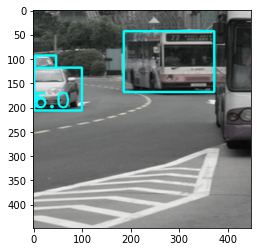

In [32]:
# %matplotlib inline
import matplotlib.pyplot as plt
import cv2

for idx, (image, lables, object_nums) in enumerate(train_dataset) :
    np_img = image.numpy()[0]
    np_img = np_img.astype(np.uint8)
    label = lables.numpy()[0]
    for i in range(len(lables.numpy())):
        for j in range(len(lables.numpy()[i])):
            label = lables.numpy()[i][j]
            if label[:5].tolist() == [0. ,0. ,0. ,0. ,0.]:
                break
            else:
                print(label)
                cv2.rectangle(np_img, (int(label[0]-label[2]/2), int(label[1]-label[3]/2)), 
                                      (int(label[0]+label[2]/2), int(label[1]+label[3]/2)), 
                                      (0, 255, 255), 3)
                cv2.putText(np_img, str(label[4]), (0, 200), 2, 1.5, (0, 255, 255), 2)
                print(label[4])
    plt.imshow(np_img)
    plt.show()
    if idx == 0:
        break

# Building the model

For the model, we primarily use VGG19 pre-trained on ImageNet as our feature extractor, before passing to the final four layers of YOLO. Between each of the final four YOLO layers, we also added Batch Normalization to allow faster convergence, as detailed in the paper for YOLOv2 (or YOLO9000)

In [12]:
class conv_leaky_relu(keras.layers.Layer):
    """
    Add batch normalization layer so that the model could converage faster
    """
    def __init__(self, filters, size, stride):
        super(conv_leaky_relu, self).__init__()
        self.conv = layers.Conv2D(filters, size, stride, padding="same",
                      kernel_initializer=tf.keras.initializers.TruncatedNormal())  # TruncatedNormal
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.1)

    def call(self, inputs, training=False):
        x = self.conv(inputs, training=training)
        x = self.batchnorm(x, training=training)
        x = self.lrelu(x, training=training)
        return x

In [13]:
class VGG19YOLO(keras.models.Model):
    def __init__(self, vgg_trainable=False):
        super(VGG19YOLO, self).__init__()
        """
        Implement the YOLO model based on the architecture on the original paper.
        We use VGG19 as our feature extractor.
        Also, as the paper suggested, we enlarge the image size to (448, 448, 3) to get 
        better image resolution.
        We also try using ResNet152 as the feature extractor, but the performance didn't
        change significantly.
        """
#         self.vgg = modified_vgg19(vgg_trainable)
        self.vgg = tf.keras.applications.VGG19(include_top=False,
                                        weights='imagenet',
                                        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
#         self.vgg = tf.keras.applications.ResNet152(
#                                             include_top=False, 
#                                             weights='imagenet', 
#                                             input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
#                                         )
        self.vgg.trainable = vgg_trainable
        
        self.clr21 = conv_leaky_relu(1024, 3, 1)
        self.clr22 = conv_leaky_relu(1024, 3, 2)
        self.clr23 = conv_leaky_relu(1024, 3, 1)
        self.clr24 = conv_leaky_relu(1024, 3, 1)
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(4096, 
                         kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))
        self.lrelu1 = layers.LeakyReLU(0.1)
        self.do = layers.Dropout(0.5)
        self.dense2 = layers.Dense(CELL_SIZE * CELL_SIZE * (NUM_CLASSES + BOXES_PER_CELL + BOXES_PER_CELL *4),#1470, 
                               kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))

    def call(self, inputs, training=False):
        x = tf.keras.applications.vgg19.preprocess_input(inputs)
        x = self.vgg(x, training=training)

        x = self.clr21(x, training=training)
        x = self.clr22(x, training=training)
        x = self.clr23(x, training=training)
        x = self.clr24(x, training=training)
        x = self.flatten(x, training=training)
        x = self.dense1(x, training=training)
        x = self.lrelu1(x, training=training)
        x = self.do(x, training=training)
        x = self.dense2(x, training=training)
        return x

In [14]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x, 
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

## IoU and loss function

In [ ]:
def iou(boxes1, boxes2):
    #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 =  tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                      boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

    #calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    #calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    #intersection
    intersection = rd - lu 

    #the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

    #if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    #calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square/(square1 + square2 - inter_square + 1e-6)

def losses_calculation(args):
    predict, label = args
    label = tf.reshape(label, [-1])

    #Step A. calculate objects tensor [CELL_SIZE, CELL_SIZE]
    #turn pixel position into cell position (corner)
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    
    min_x = tf.floor(min_x)
    min_y = tf.floor(min_y)

    max_x = tf.minimum(tf.math.ceil(max_x), CELL_SIZE)
    max_y = tf.minimum(tf.math.ceil(max_y), CELL_SIZE)
    
    #calculate mask of object with cells
    onset = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    object_mask = tf.ones(onset, tf.float32)

    offset = tf.cast(tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]), tf.int32)
    offset = tf.reshape(offset, (2, 2))
    object_mask = tf.pad(object_mask, offset, "CONSTANT")

    #Step B. calculate the coordination of object center and the corresponding mask
    #turn pixel position into cell position (center)
    center_x = label[0] / (IMAGE_SIZE / CELL_SIZE)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / CELL_SIZE)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    #calculate the coordination of object center with cells
    objects_center_coord = tf.cast(tf.stack([center_y, CELL_SIZE - center_y - 1, 
                             center_x, CELL_SIZE - center_x - 1]), 
                             tf.int32)
    objects_center_coord = tf.reshape(objects_center_coord, (2, 2))

    #make mask
    response = tf.pad(response, objects_center_coord, "CONSTANT")

    #Step C. calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    predict_boxes = predict[:, :, NUM_CLASSES + BOXES_PER_CELL:]

    predict_boxes = tf.reshape(predict_boxes, [CELL_SIZE, 
                                               CELL_SIZE, 
                                               BOXES_PER_CELL, 4])
    #cell position to pixel position
    predict_boxes = predict_boxes * [IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE, IMAGE_SIZE]

    #if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = iou(predict_boxes, label[0:4])

    #calculate C tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    #calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    I = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    max_I = tf.reduce_max(I, 2, keepdims=True)

    #replace large iou scores with response (object center) value
    #only keep the one response predictor in the cell
    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    #calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES:NUM_CLASSES + BOXES_PER_CELL]

    #calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    #calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    p_sqrt_w = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
    p_sqrt_h = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))

    #calculate ground truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    #calculate predicted p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:NUM_CLASSES]

    #class_loss
    class_loss = tf.nn.l2_loss(tf.reshape(object_mask, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE

    #object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE

    #noobject_loss
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * NOOBJECT_SCALE

    #coord_loss
    coord_loss = (tf.nn.l2_loss(I * (p_x - x)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_y - y)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w))/IMAGE_SIZE +
                  tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h))/IMAGE_SIZE) * COORD_SCALE

    return class_loss + object_loss + noobject_loss + coord_loss

# Model training setup

If we have more than 1 gpu, then we can use data parallelism to speed up the training process.
We set `LEARNING_RATE = 1.5*1e-5` to avoid overshoot (exploding gradient).

In [17]:
if DATA_PARALLELISM:
    mirrored_strategy = tf.distribute.MirroredStrategy(devices=logical_gpus)

    with mirrored_strategy.scope():
        vgg19_yolo = VGG19YOLO(vgg_trainable=VGG_TRAINABLE)
        vgg19_yolo.compile()
        optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
        
    train_dist_dataset = mirrored_strategy.experimental_distribute_dataset(train_dataset)
    val_dist_dataset = mirrored_strategy.experimental_distribute_dataset(val_dataset)
else:
    vgg19_yolo = VGG19YOLO(vgg_trainable=VGG_TRAINABLE)
    vgg19_yolo.compile()

    optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
    
train_loss_metric = tf.keras.metrics.Mean(name='loss')
valid_loss_metric = tf.keras.metrics.Mean(name='loss')

In [18]:
CKP_DIR = './ckpts/yolo_6'
init_epoch = 1

last_ckp = tf.train.latest_checkpoint(CKP_DIR)

if last_ckp:
    init_epoch = int(last_ckp.split('-')[-1]) + 1
    ckpt = tf.train.Checkpoint(epoch=tf.Variable(init_epoch-1), net=vgg19_yolo)
    ckpt.restore(last_ckp)
    print(f'Resume training from epoch {init_epoch-1}')
else:
    ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=vgg19_yolo)
    print('First time training')
    
manager = tf.train.CheckpointManager(ckpt, CKP_DIR, max_to_keep=30, checkpoint_name='yolo')

First time training


# Loss function

The loss function is the same as provided in the sample, but we adjusted it to allow parallelization with `tf.map_fn`.

In [ ]:
def yolo_loss(args):
    """
    Implement parallelizing computing by tf.map_fn
    """
    def loss(args):
        predict, label = args
        return losses_calculation((predict, label))
    
    predict, label, object_num = args
    
    # duplicate predict for parallelizing
    predict = tf.tile(predict, [object_num, 1, 1])
    predict = tf.reshape(predict, (-1, CELL_SIZE, CELL_SIZE, (NUM_CLASSES + BOXES_PER_CELL + BOXES_PER_CELL*4)))

    loss_per_object = tf.map_fn(loss, (predict, label[:object_num, :]), fn_output_signature=tf.float32)
        
    return tf.reduce_sum(loss_per_object)/BATCH_SIZE

# Train step, validation step, and data parallelism

Same with loss function, `tf.map_fn` is applied to allow for parallelization.

We also implemented gradient clipping to avoid overshoot (exploding gradients).

In [20]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = vgg19_yolo(image, training=True)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, CELL_SIZE, CELL_SIZE, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, CELL_SIZE, CELL_SIZE, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, CELL_SIZE, CELL_SIZE, 2*4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        # Implement parallelizing computing by tf.map_fn
        loss = tf.map_fn(yolo_loss, (predicts, labels, objects_num), fn_output_signature=tf.float32)
        loss = tf.reduce_sum(loss)
        train_loss_metric(loss)

    grads = tape.gradient(loss, vgg19_yolo.trainable_weights)
    # Implement gradient cliping
    gradients = [(tf.clip_by_value(grad, -1.0, 1.0)) for grad in grads]
    optimizer.apply_gradients(zip(grads, vgg19_yolo.trainable_weights))
    
    return loss

In [21]:
@tf.function
def validation_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = vgg19_yolo(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, CELL_SIZE, CELL_SIZE, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, CELL_SIZE, CELL_SIZE, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, CELL_SIZE, CELL_SIZE, 2*4))
        predicts = tf.concat([class_probs, confs, boxes], 3)
#         Implement parallelizing computing by tf.map_fn
        loss = tf.map_fn(yolo_loss, (predicts, labels, objects_num), fn_output_signature=tf.float32)
        loss = tf.reduce_sum(loss)
        valid_loss_metric(loss)
    
    return loss

In [22]:
# Implement data parallelism
if DATA_PARALLELISM:
    @tf.function
    def distributed_train_step(dist_inputs):
        image, labels, objects_num = dist_inputs
        per_replica_losses = mirrored_strategy.run(train_step, args=(image, labels, objects_num))
        return mirrored_strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)

In [23]:
# Implement data parallelism
if DATA_PARALLELISM:
    @tf.function
    def distributed_validation_step(dist_inputs):
        image, labels, objects_num, img_w, img_h, img_name = dist_inputs
        per_replica_losses = mirrored_strategy.run(validation_step, args=(image, labels, objects_num))
        return mirrored_strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)

# Training

## Data Parallelism among GPU

In [ ]:
print("{}, start training.".format(datetime.now()))

for i in range(init_epoch, EPOCHS+1):
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    # Implement data parallelism
    if DATA_PARALLELISM:
        for step, dist_inputs in enumerate(train_dist_dataset):
            distributed_train_step(dist_inputs)
            print(f'{step+1:>5} - loss: {train_loss_metric.result():,.2f}', end='\r') 

        # validation
        for dist_inputs in val_dist_dataset:
            distributed_validation_step(dist_inputs)
    else:
        for step, (image, labels, objects_num) in enumerate(train_dataset):
            train_step(image, labels, objects_num)
            print(f'{step+1:>5} - loss: {train_loss_metric.result():,.2f}', end='\r') 

        # validation
        for image, labels, objects_num, img_w, img_h, img_name in val_dataset:
            validation_step(image, labels, objects_num)

    # train loss and validation loss after one epoch
    output_str = "{}, Epoch {}: train loss {:.2f}, valid loss {:.2f}".format(datetime.now(), i, train_loss_metric.result(), valid_loss_metric.result())
    print(output_str)

    # write log to the log file
    f = open('./yolo_log_6','a')
    f.write(output_str+"\n")
    f.close()

    # save checkpoint
    save_path = manager.save()
    print("{}, Saved checkpoint for epoch {}: {}".format(datetime.now(), int(ckpt.epoch), save_path))

2020-12-03 02:17:00.836575, start training.
2020-12-03 02:25:34.974174, Epoch 1: train loss 15.52, valid loss 10.66
2020-12-03 02:27:06.904188, Saved checkpoint for epoch 1: ./ckpts/yolo_6/yolo-1


# Testing

## Apply on val dataset and calculate mAP

In [72]:
@tf.function
def prediction_step(img):
    return vgg19_yolo(img, training=False)

In [113]:
# generate prediction
CONF_THRESHOLD = 0.015
NMS_IOU_THRESHOLD = 0.1
MAX_PRED_LABELS = 20

In [ ]:
def process_outputs_max(outputs):
    """
    Find the hightest confidence box and output as prediction.
    
    """
    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, CELL_SIZE, CELL_SIZE, 20))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, CELL_SIZE, CELL_SIZE, 2))
    boxes = np.reshape(outputs[:, conf_end:], (-1, CELL_SIZE, CELL_SIZE, 2*4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

    P = C * p_classes
    #P's shape [7, 7, 2, 20]

    #choose the most confidence one
    max_conf = np.max(P)
    index = np.argmax(P)

    index = np.unravel_index(index, P.shape)

    class_num = index[3]

    coordinate = np.reshape(coordinate, 
                            (CELL_SIZE, 
                             CELL_SIZE,
                             BOXES_PER_CELL, 
                             4))

    max_coordinate = coordinate[index[0], index[1], index[2], :]

    xcenter = max_coordinate[0]
    ycenter = max_coordinate[1]
    w = max_coordinate[2]
    h = max_coordinate[3]

    xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
    ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

    w = w * IMAGE_SIZE
    h = h * IMAGE_SIZE

    xmin = xcenter - w/2.0
    ymin = ycenter - h/2.0

    xmax = xmin + w
    ymax = ymin + h

    return np.array([xmin]), np.array([ymin]), np.array([xmax]), np.array([ymax]), np.array([class_num]), np.array([max_conf])

In [ ]:
def process_outputs(outputs, w, h):
    """
    Implement the non-maximum suppression algorithm to find the candidate output bounding box.
    If we didn't find any candidate, we will output the most bounding box with most confidence 
    by calling process_outputs_max() 
    """
    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, CELL_SIZE, CELL_SIZE, NUM_CLASSES))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, CELL_SIZE, CELL_SIZE, BOXES_PER_CELL))
    
    # calculate original x_center, y_center, width, height
    boxes = np.reshape(outputs[:, conf_end:], (-1, CELL_SIZE, CELL_SIZE, BOXES_PER_CELL*4))
    boxes = tf.reshape(boxes, [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4])
    boxes = boxes * [IMAGE_SIZE / CELL_SIZE, IMAGE_SIZE / CELL_SIZE, IMAGE_SIZE, IMAGE_SIZE]
    boxes = base_boxes + boxes
    boxes = tf.reshape(boxes, [-1, 4])
    
    xcs, ycs, ws, hs = tf.unstack(boxes, axis=1)
    
    xmins = xcs - ws/2.0
    ymins = ycs - hs/2.0
    
    xmaxs = xmins + ws
    ymaxs = ymins + hs
    
    # in order to call tf.image.non_max_suppression
    # the coordinate order need to be(y_min, x_min, y_max, x_max)
    boxes = tf.stack([ymins, xmins, ymaxs, xmaxs], axis=1)
    # duplicate boxes with 20 classes
    boxes = tf.repeat(boxes, repeats=NUM_CLASSES, axis=0)
    
    class_probs = np.reshape(class_probs, (CELL_SIZE, CELL_SIZE, 1, 20))
    confs = np.reshape(confs, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))
    scores = confs * class_probs
    scores = tf.reshape(scores, (-1)) 
    
    class_nums_ref = tf.tile(
        tf.range(NUM_CLASSES), [CELL_SIZE*CELL_SIZE*BOXES_PER_CELL]
    )
    
    # filter out boxes that is out of image
    area_filter = tf.greater(
        tf.maximum(xmaxs - xmins, 0.0)
        * tf.maximum(ymaxs - ymins, 0.0),
        0.0
    )
    # duplicate boxes with 20 classes
    area_filter = tf.repeat(area_filter, repeats=NUM_CLASSES, axis=0)
    
    boundary_filter = tf.logical_and(
        tf.logical_and(
            tf.greater_equal(xmins, 0),
            tf.greater_equal(ymins, 0)
        ),
        tf.logical_and(
            tf.less(xmaxs, w),
            tf.less(ymaxs, h)
        )
    )
    # duplicate boxes with 20 classes
    boundary_filter = tf.repeat(boundary_filter, repeats=NUM_CLASSES, axis=0)

    conf_filter = tf.greater_equal(scores, CONF_THRESHOLD)
    
    object_filter = tf.logical_and(area_filter, conf_filter)
    object_filter = tf.logical_and(object_filter, boundary_filter)
    
    boxes = tf.boolean_mask(boxes, object_filter)
    scores = tf.boolean_mask(scores, object_filter)
    class_nums_ref = tf.boolean_mask(class_nums_ref, object_filter)
    
    # scores shape: [CELL_SIZE * CELL_SIZE * BOXES_PER_CELL * NUM_CLASSES]
    # boxes shape: [CELL_SIZE * CELL_SIZE * BOXES_PER_CELL * NUM_CLASSES, 4]
    # ==> (y_min, x_min, y_max, x_max)
    selected_indices = tf.image.non_max_suppression(
        boxes, scores, MAX_PRED_LABELS, iou_threshold=NMS_IOU_THRESHOLD,
    )

    if len(selected_indices) > 0:
        selected_boxes = tf.gather(boxes, selected_indices)

        ymins, xmins, ymaxs, xmaxs = tf.split(selected_boxes, 4, axis=1)
        xmins = tf.cast(tf.reshape(xmins, (-1)), tf.float32)
        ymins = tf.cast(tf.reshape(ymins, (-1)), tf.float32)
        xmaxs = tf.cast(tf.reshape(xmaxs, (-1)), tf.float32)
        ymaxs = tf.cast(tf.reshape(ymaxs, (-1)), tf.float32)

        class_nums = tf.cast(tf.gather(class_nums_ref, selected_indices), tf.int32)
        confs = tf.cast(tf.gather(scores, selected_indices), tf.float32)

        return xmins, ymins, xmaxs, ymaxs, class_nums, confs
    else:
        # if there is no output candidate, 
        # then output the bounding box with most confidence
        return process_outputs_max(outputs)

### Generate validation
(output format is a little bit different with the given sample code)

In [115]:
val_prediction_file_txt = './yolo_4_val_prediction_ep51.txt'
val_prediction_file_csv = './yolo_4_val_prediction_ep51.csv'

In [116]:
# generate validation file
output_file = open(val_prediction_file_txt, 'w')
print("{}, start validation.".format(datetime.now()))

for idx, (image, labels, objects_num, img_w, img_h, img_name) in enumerate(val_dataset):
    batch_num = image.shape[0]
    for i in range(batch_num):
        w = float(img_w[i])
        h = float(img_h[i])
        
        xmins, ymins, xmaxs, ymaxs, class_nums, confs = process_outputs(prediction_step(image[i:i+1]), w, h)

        xmins = xmins * w / float(IMAGE_SIZE)
        ymins = ymins * h / float(IMAGE_SIZE)
        xmaxs = xmaxs * w / float(IMAGE_SIZE)
        ymaxs = ymaxs * h / float(IMAGE_SIZE)

        datastring = img_name[i:i+1].numpy()[0].decode('ascii')
        for i in range(len(class_nums)):
            class_name = classes_name[class_nums[i]]
            datastring += " %d %d %d %d %d %f" %(xmins[i], ymins[i], xmaxs[i], ymaxs[i], class_nums[i], confs[i])
            
        datastring += "\n"
        output_file.write(datastring)

output_file.close()

print("{}, end validation.".format(datetime.now()))

2020-12-03 00:22:51.103855, start validation.
2020-12-03 00:23:08.313213, end validation.


# Calculate mAP

Here we used an external package to calculate mAP.

## Generate ground truth
Has already generated during val-dataset generation

## Generate prediction

In [104]:
# generate validation file for using package to calculate mAP
# package: https://github.com/Cartucho/mAP
print("{}, start validation.".format(datetime.now()))

for idx, (image, labels, objects_num, img_w, img_h, img_name) in enumerate(val_dataset):
    batch_num = image.shape[0]
    for i in range(batch_num):
        f = open(VAL_PRED_DIR + img_name.numpy()[i][:-4].decode('UTF-8') + '.txt', 'w')
        w = float(img_w[i])
        h = float(img_h[i])
        xmins, ymins, xmaxs, ymaxs, classes, confs = process_outputs(prediction_step(image[i:i+1]), w, h)

        xmins = xmins * w / float(IMAGE_SIZE)
        ymins = ymins * h / float(IMAGE_SIZE)
        xmaxs = xmaxs * w / float(IMAGE_SIZE)
        ymaxs = ymaxs * h / float(IMAGE_SIZE)
        
        datastring = ""
        for i in range(len(classes)):
            class_name = classes_name[classes[i]]
            datastring += "%s %f %d %d %d %d\n" %(class_name, confs[i], xmins[i], ymins[i], xmaxs[i], ymaxs[i])
            
        f.write(datastring)
        f.close()

print("{}, end validation.".format(datetime.now())) 

2020-12-02 23:25:49.021176, start validation.
2020-12-02 23:26:05.256362, end validation.


## Draw Prediction Image

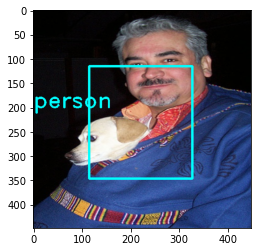

In [47]:
# draw all the predicted bounding boxes on the image
np_img = cv2.imread('./data/VOCdevkit_test/VOC2007/JPEGImages/000001.jpg')
resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
resized_img = np_img
np_img = np_img.astype(np.float32)
np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))

y_pred = vgg19_yolo(np_img, training=False)
xmins, ymins, xmaxs, ymaxs, class_nums, confs = process_outputs(y_pred)
for xmin, ymin, xmax, ymax, class_num, conf in zip(xmins, ymins, xmaxs, ymaxs, class_nums, confs):
    class_name = classes_name[class_num]
    cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 255), 3)
    cv2.putText(resized_img, class_name, (0, 200), 2, 1.5, (0, 255, 255), 2)
    print(class_num)

plt.imshow(resized_img)
plt.show()

# Apply on test dataset

In [105]:
test_img_files = open('./data/pascal_voc_testing_data.txt')
test_img_dir = './data/VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
#     image = (image/255) * 2 - 1

    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [106]:
test_prediction_file_txt = './yolo_4_test_prediction_ep51.txt'
test_prediction_file_csv = './yolo_4_test_prediction_ep51.csv'

In [111]:
# gen file
output_file = open(test_prediction_file_txt, 'w')
print("{}, start predicting test data.".format(datetime.now()))

for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        w = float(img_w[i])
        h = float(img_h[i])
        xmins, ymins, xmaxs, ymaxs, class_nums, confs = process_outputs(prediction_step(image[i:i+1]), w, h)
        xmins = xmins * w / float(IMAGE_SIZE)
        ymins = ymins * h / float(IMAGE_SIZE)
        xmaxs = xmaxs * w / float(IMAGE_SIZE)
        ymaxs = ymaxs * h / float(IMAGE_SIZE)

        datastring = img_name[i:i+1].numpy()[0].decode('ascii')
        for i in range(len(class_nums)):
            class_name = classes_name[class_nums[i]]
            datastring += " %d %d %d %d %d %f" %(xmins[i], ymins[i], xmaxs[i], ymaxs[i], class_nums[i], confs[i])
            
        datastring += "\n"
        output_file.write(datastring)

output_file.close()

print("{}, end predicting test data.".format(datetime.now()))

2020-12-03 00:01:11.374955, start predicting test data.
2020-12-03 00:02:53.856665, end predicting test data.


In [112]:
eval_gen.evaluate(test_prediction_file_txt, test_prediction_file_csv)

End Evalutation


# Report

## Few things we implement in this competition
1. Data augmentation
    * The number of data and the quality of data can really impact the performance of NN. In our experiment, the results come from data with and without augmentation can have significant difference.
    * Data augmentation is really a skill. In the experiment, I tried to rotate the images for 90 and 270 degree, but it causes the NN perform bad since the image was rotated too much.
2. Parallel loss function computation
    * We implement *tf.map_fn* to parallel compute loss function, but the training process does not improve significantly. Still need to confirm why.
    * Encounter bugs that we cannot solve during implementing *tf.vectorized_map* so we give up.
3. Data parallelism among multiple gpus
    * After our experiment, data parallelism can significantly speed up the training process only when the batch size is large (40 or larger).
    * The training process does not speed up when the batch size is small (under 16).
4. Non-maximum suppression algorithm (NMS)
    * The performance didn't improve after we implement NMS. In fact, the preformance even get worse by around 7-8%.
    * After we look into the prediction result of our model, we find out that our model tend to make low confidence score (<0.2). Low confidence score make it difficult to adjust the threshold of the NMS algorithm.
    * We try to retrain our model with higher penalty on confidence score after the above finding. Unfortunately we didn't catch up the deadline to submit the result.
5. Other feature extractors and model modifications
    * Aside from VGG19, we also tried implementing ResNet and Xception as our feature extraction architecture. We also tried tweaking the hyperparameters such as `CELL_SIZE` to allow for easier adjustment from the pre-trained layers to the final layers. We also experimented with using a learning rate scheduler to hopefully allow for faster convergence without running into overshooting problem, but all of these adjustments have little to no improvements, some even make the performance worse.
    
## Few things we didn't do well this time and hope to improve in the next competition
1. Didn't find a proper metrics to validate our model's performance
    * The best score we got on the public leaderboard is around 0.56. But when we use the [package](https://github.com/Cartucho/mAP) to calculate mAP score on validation set, we only got around 0.03, which is very huge gap.
    * We ignore the most important validation metric during the competition. After all, we suffered a lot because we cannot decide the performance between the different models we train.
    * We will make sure we get the proper validation metric on the next competition.
2. Need to manage the progress well during the competition
    * We implement the NMS algorithm and get lower performance. One reason is that we didn't get enough time to experiment and adjust the threshold of the NMS algorithm. Also, we didn't have proper metric to evaluate the performance between different threshold setup.
    * Need to get proper validation metric at the begining of the competition next time.